# Détection de visage - SY32

### Import des librairies
On définit également les chemins principaux et on charge le fichier de données.

In [95]:
import numpy as np
from skimage import io
from skimage import util
from skimage.transform import resize
#from skimage import color
#from skimage import feature
from sklearn import svm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


absolutePath = "/Users/guillaume/Cloud/WORK/UTC/GI02/SY32/TDXu/Projet/"
pathTrain = absolutePath + "projetface/train/"
pathTest =  absolutePath + "projetface/test/"
pathFile = absolutePath + "projetface/label.txt"
data = np.loadtxt(pathFile)

Les fenêtres étant de tailles différentes, il est nécessaire de connaître la taille de fenêtre la plus petite dont nous disposons afin que nous ne soyons pas contraints de zoomer une image.

In [96]:
def smallestFace(data):
    return np.min(data[:,3:])

print("smallestFace =", smallestFace(data))

smallestFace = 30.0


La fonction suivante permet tout simplement d'afficher une image d'apprentissage en affichant dessus son rectangle correspondant.

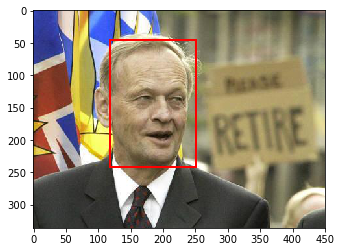

In [119]:
def afficherImgRect(n, data, pathTrain):
    # Charger l'image
    img = np.array(Image.open(pathTrain +"%04d"%(n)+".jpg"), dtype=np.uint8)
    # Créer la figure et les axes
    fig,ax = plt.subplots(1)
    # Afficher l'image
    ax.imshow(img)
    # Créer le rectangle 
    xcorner, ycorner, width, height = data[n-1][1:]
    rect = patches.Rectangle((xcorner, ycorner), width, height,linewidth=2,edgecolor='r', facecolor='none')
    # Ajouter le rectangle sur l'image
    ax.add_patch(rect)
    plt.show()

afficherImgRect(14, data, pathTrain)

La fonction suivante permet de cropper l'image selon ce rectangle.

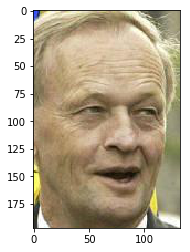

In [98]:
def cropImage(n, data, pathTrain):
    img = np.array(Image.open(pathTrain +"%04d"%(n)+".jpg"), dtype=np.uint8)
    x, y, w, h = map(int, data[n-1][1:])
    img = img[y:y+h, x:x+w]
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    plt.show()

cropImage(14,data,pathTrain)

Pour des questions de simplicité, nous voudrions que les images croppées soient carrées de la taille minimale calculée précédemment.

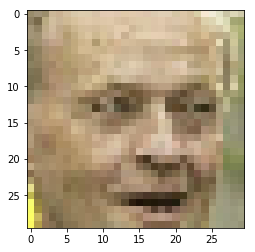

In [114]:
def cropImageSquare(n, data, pathTrain, newsize):
    # Chargement de l'image
    img = np.array(Image.open(pathTrain +"%04d"%(n)+".jpg"), dtype=np.uint8)
    # Récupération du rectangle
    x, y, w, h = map(int, data[n-1][1:])
    # Transformation en carré
    minwh = min(w,h)
    x+=(w-minwh)//2 # Pour centrer le carré //2
    y+=(h-minwh)//2
    # Recadrement de l'image
    img = img[y:y+minwh, x:x+minwh]
    # Redimensionnement de l'image
    img = resize(img, (newsize, newsize), mode='reflect')
    # Affichage de l'image
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    plt.show()

cropImageSquare(14,data,pathTrain, 30)

Grâce à la fonction précédente, nous obtenons nos exemples positifs d'apprentissage. Il nous faut également générer des exemples négatifs de façon aléatoire, ceux-ci devant recouvrir au plus 50% de l'exemple positif. Écrivons donc une fonction permettant d'obtenir le taux de recouvrement relatif à deux fenêtres (entre 0 et 100%).

In [120]:
def recouvrement(x1, y1, w1, h1, x2, y2, w2, h2):
    xinter = max(0, min(x1+w1,x2+w2) - max(x1,x2))
    yinter = max(0, min(y1+h1,y2+h2) - max(y1,y2));
    ainter = xinter * yinter;
    aunion = (w1*h1) + (w2*h2) - ainter
    return ainter/aunion

print("Recouvrement total:", recouvrement(10,10,30,30,10,10,30,30))
print("Recouvrement nul:", recouvrement(10,10,30,30,40,40,30,30))
print("Recouvrement partiel:", recouvrement(10,10,30,30,20,20,30,30))

Recouvrement total: 1.0
Recouvrement nul: 0.0
Recouvrement partiel: 0.2857142857142857
